In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('/home/kruu/git_folder/eye_tracking/')

from utils.data_processing import EyeTrackingProcessor, GazeMetricsProcessor, MouseMetricsProcessor

import seaborn as sns
import matplotlib.pyplot as plt

****
# Import Data
****

In [2]:
data_path = "/store/kruu/eye_tracking"
files_list = os.listdir(data_path)
files_list = [os.path.join(data_path, file) for file in files_list]

tasks = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6']
features = ['Recording timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y', 'Event', 'Participant name']
interpolate_col = ['Recording timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y', 'Blink']

processor = EyeTrackingProcessor()
all_data = processor.load_data(files_list)
dataset = processor.get_features(all_data, tasks, features)
dataset, blinks = processor.detect_blinks(dataset)

#Fixed size resampling for the whole task
dataset_point_resampled = processor.resample_tasks_fixed_points(dataset, interpolate_col, num_points=1000)
dataset_point_resampled.Blink = (dataset_point_resampled.Blink > 0.5) #Transform interpolated data

# Fixed Time step resampling
dataset_time_resampled = processor.resample_tasks_fixed_time(dataset, interpolate_col, timestep = 0.01)
dataset_time_resampled.Blink = (dataset_time_resampled.Blink > 0.5) #Transform interpolated data

/home/kruu/git_folder/eye_tracking/utils/data_processing.py:16: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')
/home/kruu/git_folder/eye_tracking/utils/data_processing.py:16: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')


In [ ]:
#WARNING: 81% of mouse data are missing. Problem for computing the velocity or the acceleration
(~dataset.isna()).sum()

Recording timestamp    1196945
Gaze point X            665034
Gaze point Y            665034
Mouse position X        224782
Mouse position Y        224782
Event                    10963
Participant name       1196945
Task_id                1196945
Task_execution         1196945
Blink                  1196945
dtype: int64

In [27]:
(~dataset_point_resampled.isna()).sum()

Recording timestamp    432000
Gaze point X           171107
Gaze point Y           171107
Mouse position X         1898
Mouse position Y         1898
Blink                  432000
Participant name       432000
Task_id                432000
Task_execution         432000
dtype: int64

In [28]:
(~dataset_time_resampled.isna()).sum()

Recording timestamp    807737
Gaze point X           404825
Gaze point Y           404825
Mouse position X         4210
Mouse position Y         4210
Blink                  807737
Participant name       807737
Task_id                807737
Task_execution         807737
dtype: int64

https://connect.tobii.com/s/article/understanding-tobii-pro-lab-eye-tracking-metrics?language=en_US#IntervalAndEventMetrics

Metrics with MouseEvent and KeyboardEvent in Event column :
- Number during the task
- Time to first click during the task
- Time from first fixation to a mouse click during the task

Fixation (slow movements). They are precomputed using the I-VT gaze filter. 
Note: with raw data, every valid eye tracking sample is treated as a fixation in the column "Eye movement type". We need to get the pre-processed data !
- Number of fixations during the task
- Time to first fixation
- First fixation location
- Whole fixation: fixation starts and ends within the same area of interest

Saccades (fast movements):
- Number
- Peak velocity
- Amplitude
- Direction: Absolute angle between a straight line from saccade start to end and a straight line from saccade start along the horizontal axis of the screen
- Latency
- First saccade in the target area of interest

Detect blinks in the setting panel?

Not finished to read the webpage...

****
# Base statistics
****

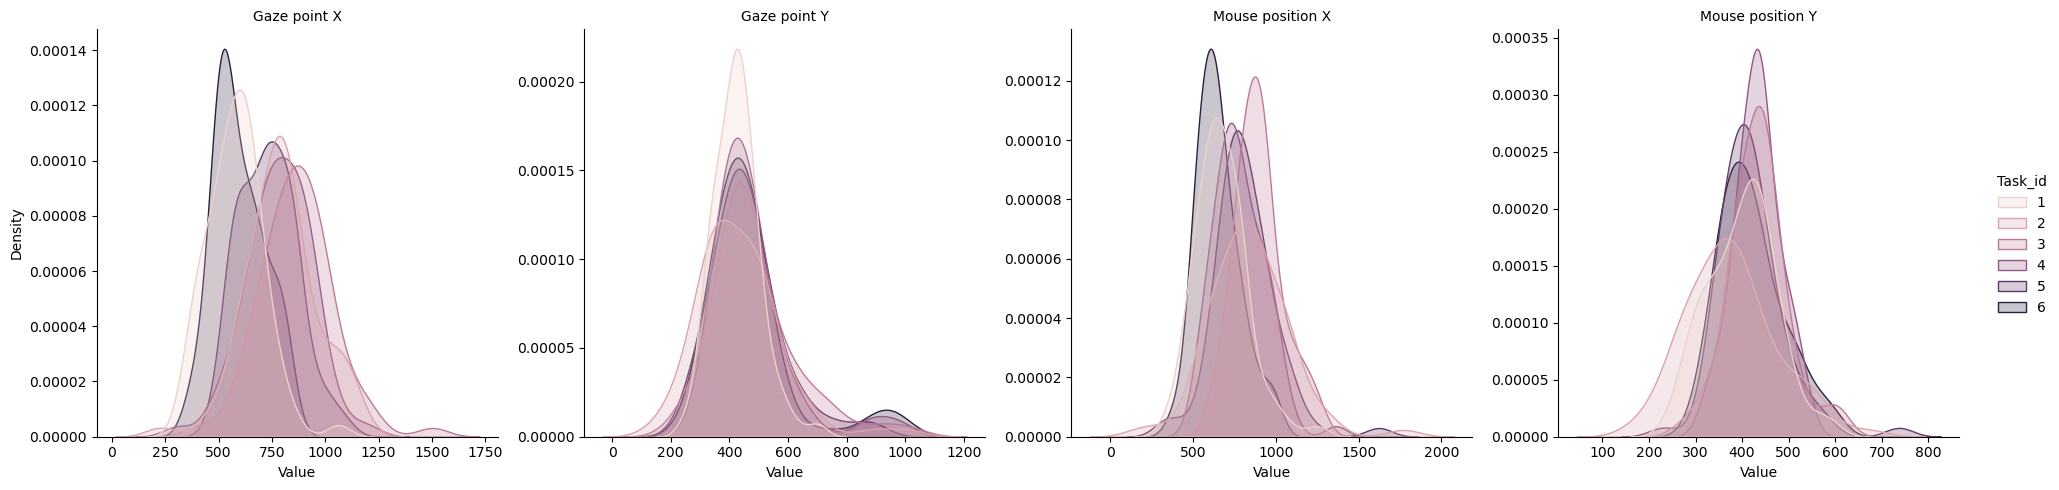

In [4]:
means = dataset.groupby(["Participant name", "Task_id", "Task_execution"])[['Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y']].mean().reset_index()

df_melted = means.melt(id_vars=['Participant name', 'Task_id', 'Task_execution'],
                    value_vars=['Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y'],
                    var_name='Measurement',
                    value_name='Value')

g = sns.displot(data=df_melted, x='Value', hue='Task_id', col='Measurement', kind='kde', fill=True, facet_kws={'sharex': False, 'sharey': False})
g.set_axis_labels('Value', 'Density')
g.set_titles('{col_name}')
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

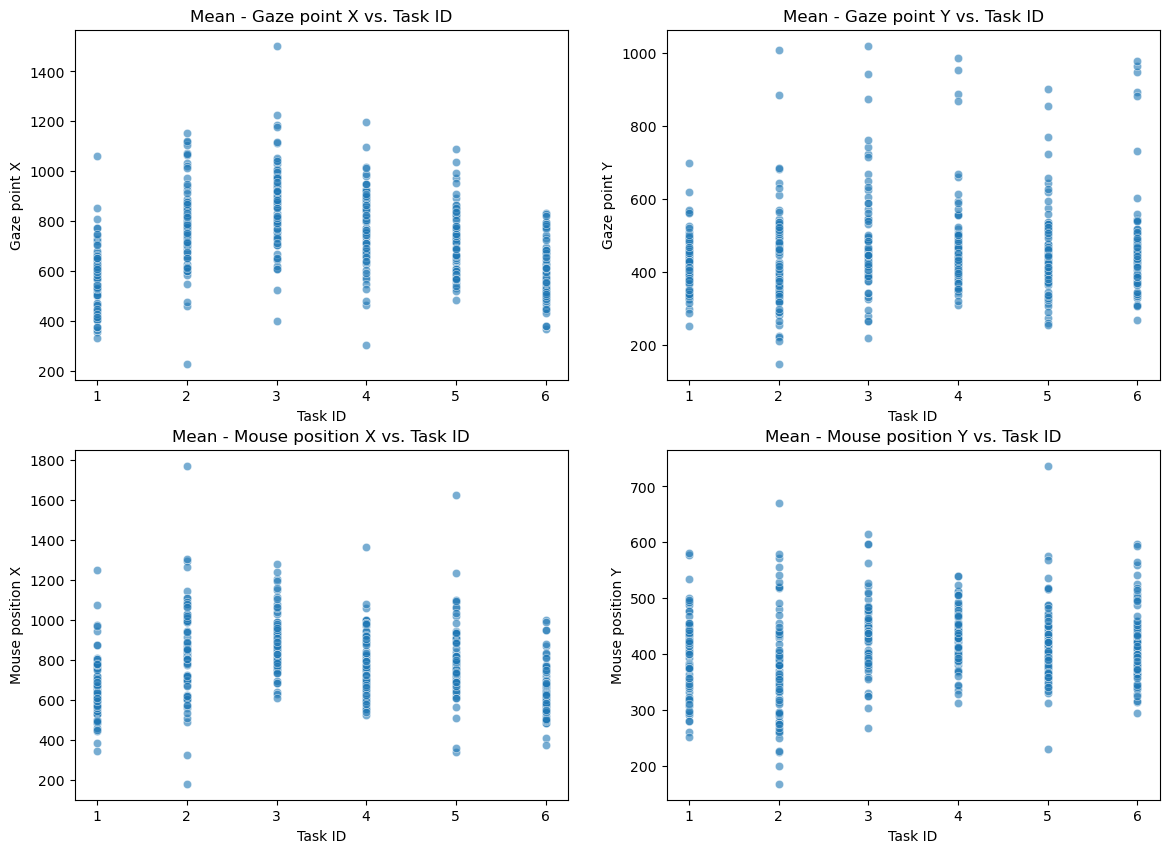

In [5]:
means = dataset.groupby(["Participant name", "Task_id", "Task_execution"])[['Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y']].mean().reset_index()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, feature in enumerate(features[1:-1]):
    row, col = divmod(i, 2)
    sns.scatterplot(data=means, x="Task_id", y=feature, alpha=0.6, ax=axes[row, col])
    axes[row, col].set_title(f"Mean - {feature} vs. Task ID")
    axes[row, col].set_xlabel("Task ID")
    axes[row, col].set_ylabel(feature)

plt.tight_layout()
plt.show()

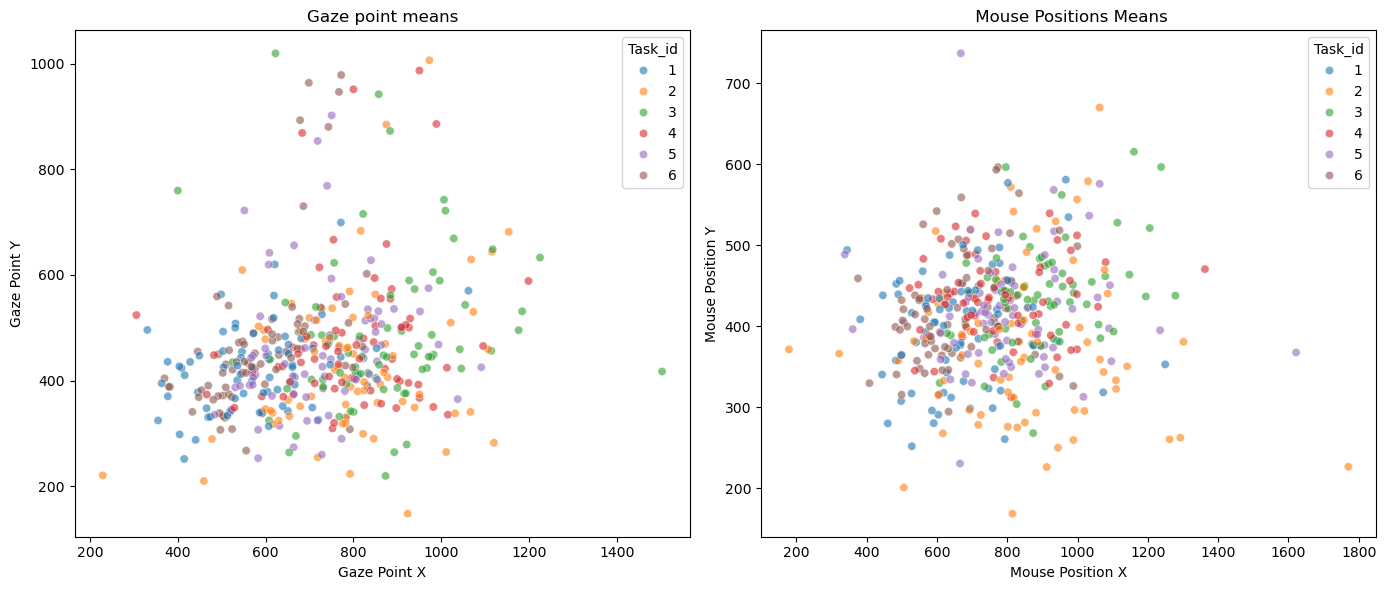

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gaze Points
sns.scatterplot(
    data=means, x="Gaze point X", y="Gaze point Y", hue="Task_id", alpha=0.6, palette="tab10", ax=axes[0]
)
axes[0].set_title("Gaze point means")
axes[0].set_xlabel("Gaze Point X")
axes[0].set_ylabel("Gaze Point Y")

# Mouse Positions
sns.scatterplot(
    data=means, x="Mouse position X", y="Mouse position Y", hue="Task_id", alpha=0.6, palette="tab10", ax=axes[1]
)
axes[1].set_title(" Mouse Positions Means")
axes[1].set_xlabel("Mouse Position X")
axes[1].set_ylabel("Mouse Position Y")

plt.tight_layout()
plt.show()

****
# Blink Identification
****

Blinks cause missing gaze data for short periods (typically 100–300ms), so we can define a blink as a continuous gap in gaze data exceeding a certain duration threshold. 

- Sort the dataset by timestamp (if not already sorted).
- Identify missing gaze points (Gaze point X or Gaze point Y is NaN).
- Compute time gaps between consecutive missing gaze points:
    - If a missing gaze entry is preceded by a valid gaze point, record its timestamp.
    - If a missing gaze entry is followed by a valid gaze point, compute the duration of the gap.
- Mark gaps exceeding a threshold (e.g., 100ms = 100,000 µs) as a blink.

In [13]:
blinks

,Blink ID,Time Diff
25,26,183326.0
67,68,249990.0
81,82,141656.0
82,83,241663.0
110,111,216655.0
...,...,...
179510,179511,324986.0
179512,179513,299987.0
179522,179523,116665.0
179523,179524,241657.0


****
# Metrics for gaze / Mouse data
****

A fixation is a group of consecutive gaze points that remain within a spatial radius (e.g. 50 pixels) for more than 100ms:
- Fixation count: Number of fixations in a task execution
- Fixation duration: Average and total duration of fixations
- Fixation dispersion: How spread-out the fixations are in a given task

Saccades are rapid eye movements between fixations:
- Saccade count: number of detected saccades
- Saccade amplitude: Euclidean distance between two consecutive fixations
- Saccade velocity: Speed of saccadic movement
- Saccade frequency: Number of saccades per second

Gaze velocity and acceleration:
- Velocity: euclidean distance per time step
- Acceleration: change in velocity per time step

Blink rate:
- Number of blinks per second

Gaze Dispersion:
- Spread of gaze points within a task execution
- Can be computed using convex hull area or bounding box width/height


In [3]:
# Group data by Task Execution
task_groups = dataset.groupby(["Participant name", "Task_id", "Task_execution"])

# Process all task executions
gaze_metrics = []
mouse_metrics = []

for (participant, task, execution), group in task_groups:
    gaze_processor = GazeMetricsProcessor(group)
    mouse_processor = MouseMetricsProcessor(group)
    gaze_compute = gaze_processor.compute_all_metrics()
    mouse_compute = mouse_processor.compute_all_metrics()
    gaze_compute.update({"Participant": participant, "Task_id": task, "Task_execution": execution})
    mouse_compute.update({"Participant": participant, "Task_id": task, "Task_execution": execution})
    gaze_metrics.append(gaze_compute)
    mouse_metrics.append(mouse_compute)

# Convert to DataFrame
gaze_metrics_df = pd.DataFrame(gaze_metrics)
mouse_metrics_df = pd.DataFrame(mouse_metrics)

/tmp/ipykernel_1719400/3999618428.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Task_id", y=metric, data=gaze_metrics_df, ax=axes[i], palette="Set2")
/tmp/ipykernel_1719400/3999618428.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Task_id", y=metric, data=gaze_metrics_df, ax=axes[i], palette="Set2")
/tmp/ipykernel_1719400/3999618428.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Task_id", y=metric, data=gaze_metrics_df, ax=axes[i], palette="Set2")
/tmp/ipykernel_1719400/3999618428.py:27: FutureWarning: 

Passing `

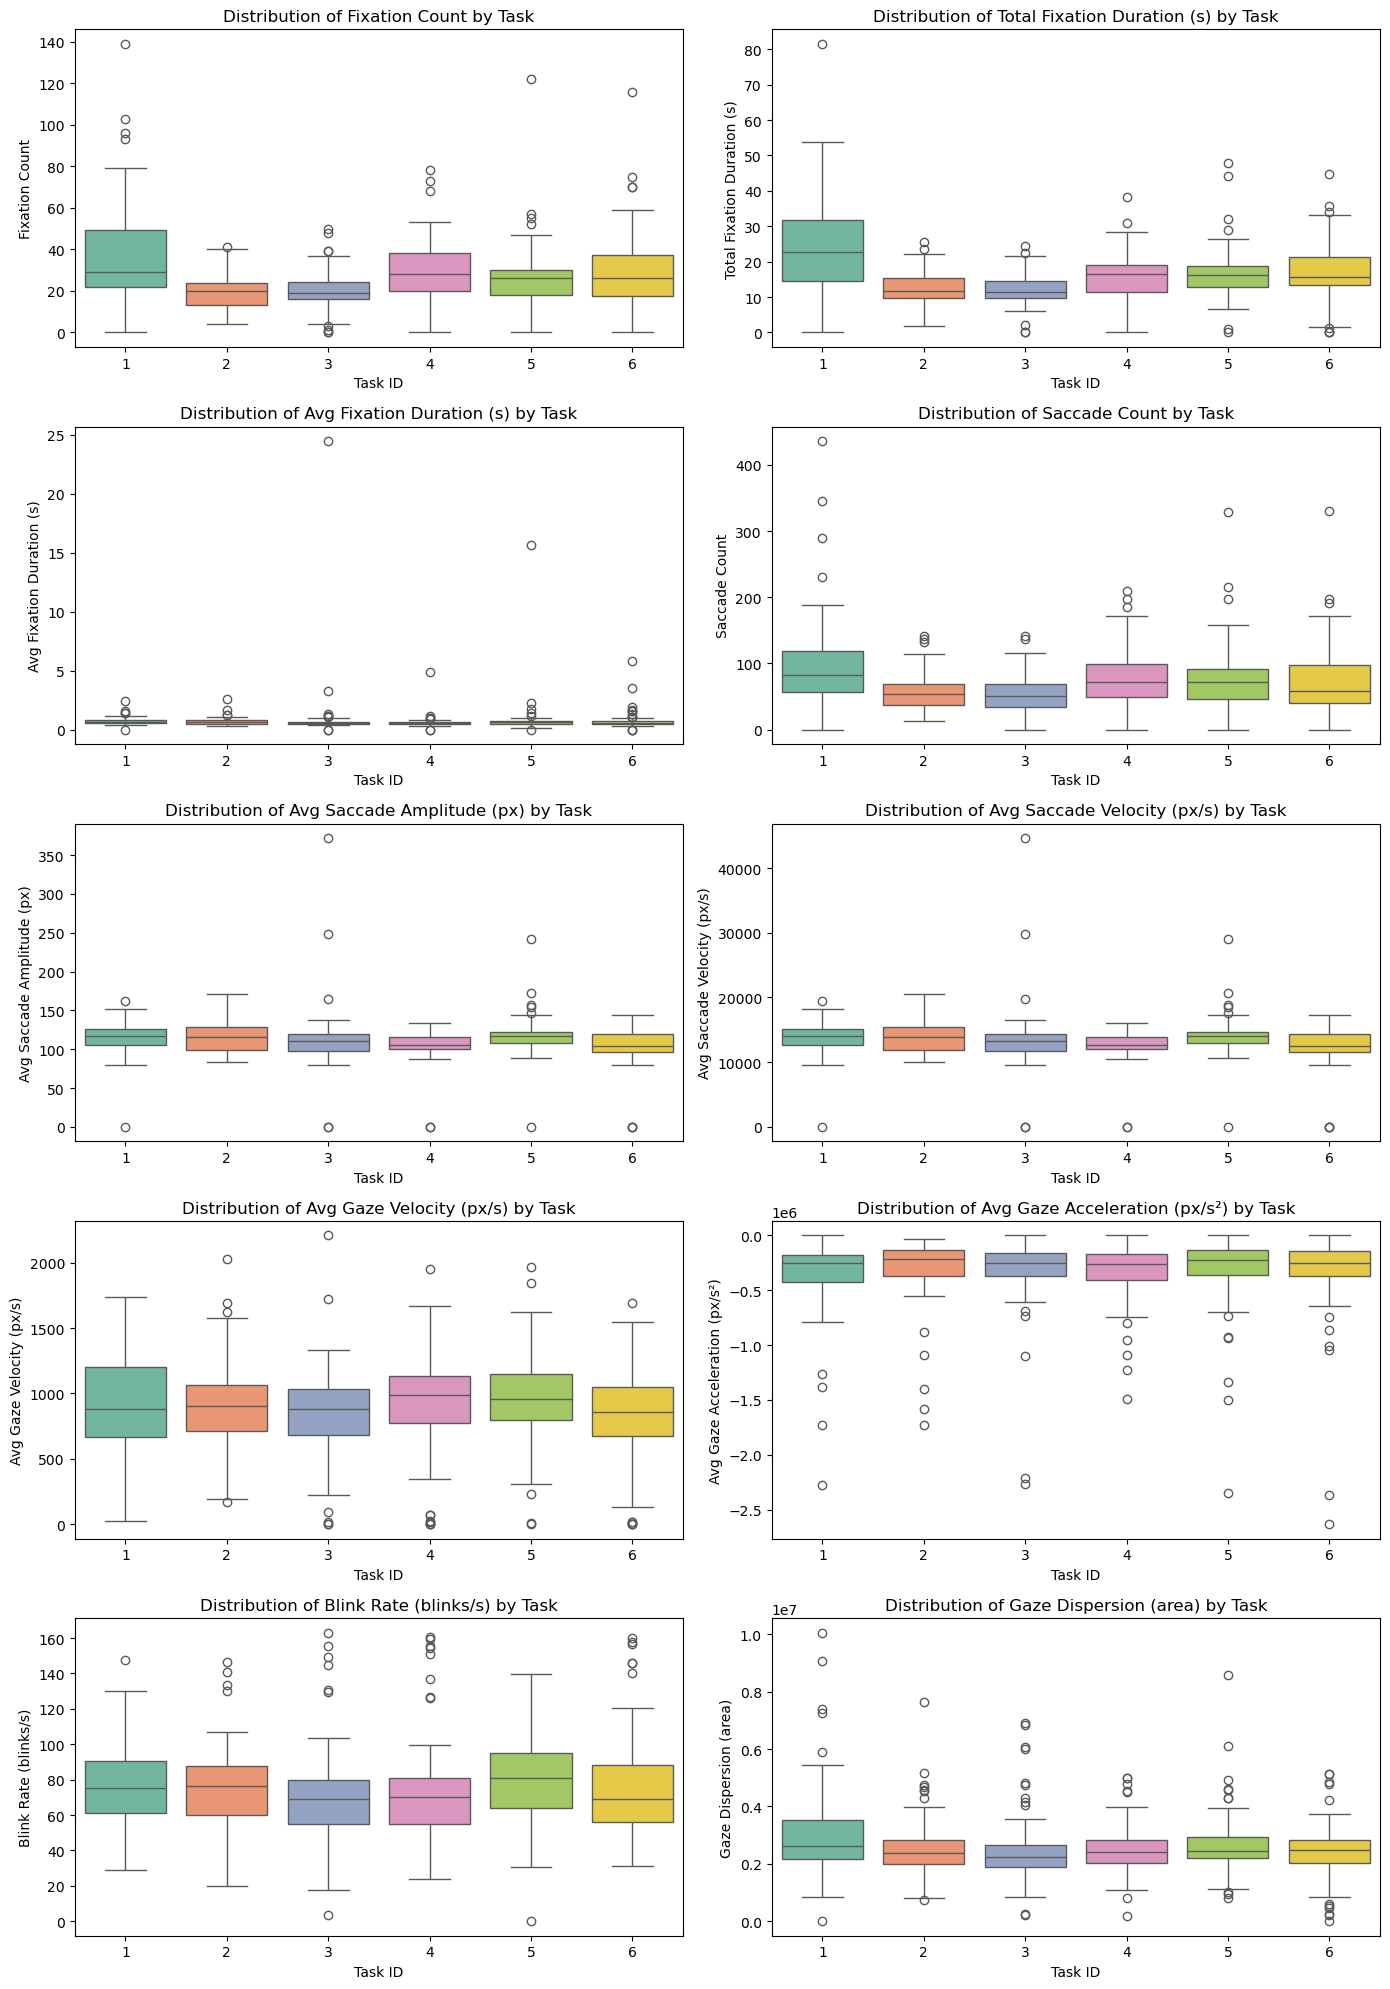

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the metrics to plot
metrics = [
    "Fixation Count",
    "Total Fixation Duration (s)",
    "Avg Fixation Duration (s)",
    "Saccade Count",
    "Avg Saccade Amplitude (px)",
    "Avg Saccade Velocity (px/s)",
    "Avg Gaze Velocity (px/s)",
    "Avg Gaze Acceleration (px/s²)",
    "Blink Rate (blinks/s)",
    "Gaze Dispersion (area)"
]

# Create a grid of subplots
num_metrics = len(metrics)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))

# Flatten axes array for easy indexing
axes = axes.flatten()

# Plot each metric distribution grouped by Task_id
for i, metric in enumerate(metrics):
    sns.boxplot(x="Task_id", y=metric, data=gaze_metrics_df, ax=axes[i], palette="Set2")
    axes[i].set_title(f"Distribution of {metric} by Task")
    axes[i].set_xlabel("Task ID")
    axes[i].set_ylabel(metric)

# Adjust layout
plt.tight_layout()
plt.show()


/tmp/ipykernel_1719400/594397312.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Task_id", y=metric, data=mouse_metrics_df, ax=axes[i], palette="Set2")
/tmp/ipykernel_1719400/594397312.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Task_id", y=metric, data=mouse_metrics_df, ax=axes[i], palette="Set2")
/tmp/ipykernel_1719400/594397312.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Task_id", y=metric, data=mouse_metrics_df, ax=axes[i], palette="Set2")
/tmp/ipykernel_1719400/594397312.py:25: FutureWarning: 

Passing `p

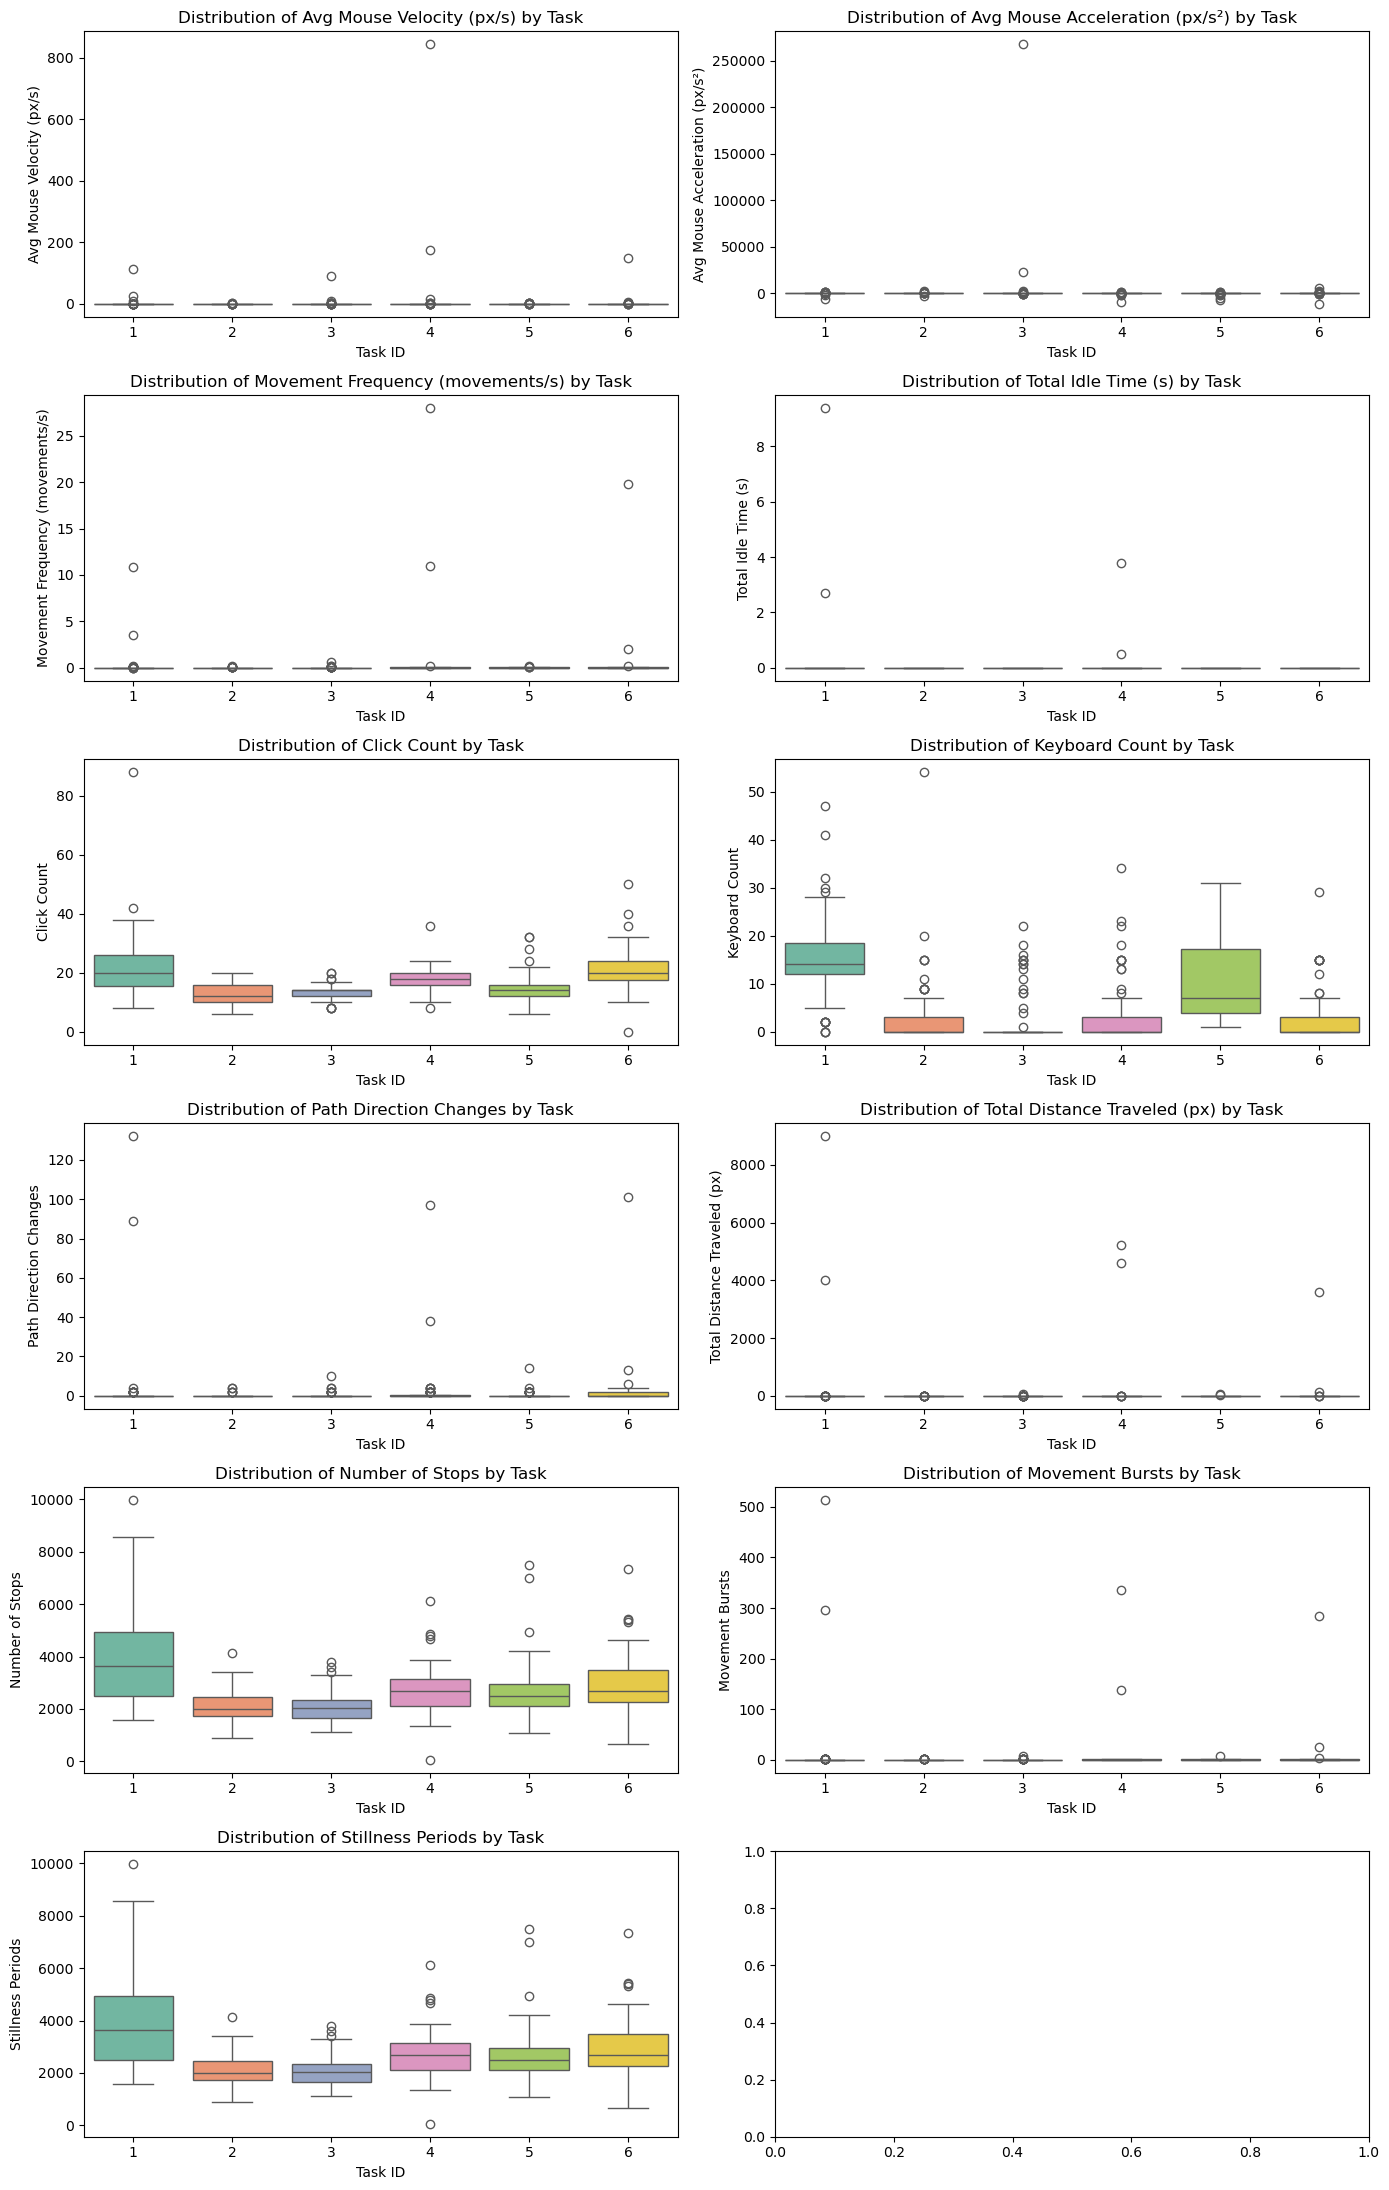

In [9]:
# Define the metrics to plot
metrics = [
    "Avg Mouse Velocity (px/s)",
    "Avg Mouse Acceleration (px/s²)",
    "Movement Frequency (movements/s)",
    "Total Idle Time (s)",
    "Click Count",
    "Keyboard Count",
    "Path Direction Changes",
    "Total Distance Traveled (px)",
    "Number of Stops",
    "Movement Bursts",
    "Stillness Periods",
]

# Create a grid of subplots
num_metrics = len(metrics)
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(14, 22))

# Flatten axes array for easy indexing
axes = axes.flatten()

# Plot each metric distribution grouped by Task_id
for i, metric in enumerate(metrics):
    sns.boxplot(x="Task_id", y=metric, data=mouse_metrics_df, ax=axes[i], palette="Set2")
    axes[i].set_title(f"Distribution of {metric} by Task")
    axes[i].set_xlabel("Task ID")
    axes[i].set_ylabel(metric)

# Adjust layout
plt.tight_layout()
plt.show()

****
# Correlation Gaze / Mouse
****

****
# TSFresh
****

In [4]:
import pandas as pd
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters

In [5]:
test = dataset.sort_values(by=["Participant name", "Task_id", "Task_execution", "Recording timestamp"])

# Fill missing values (important for tsfresh)
test["Mouse position X"] = test["Mouse position X"].ffill().bfill()
test["Mouse position Y"] = test["Mouse position Y"].ffill().bfill()
test["Gaze point X"] = test["Gaze point X"].ffill().bfill()
test["Gaze point Y"] = test["Gaze point Y"].ffill().bfill()

# Define ID column (tsfresh needs a unique identifier for each time-series)
test["id"] = test["Participant name"].astype(str) + "_" + test["Task_id"].astype(str) + "_" + test["Task_execution"].astype(str)

In [10]:
from tsfresh.feature_selection.relevance import calculate_relevance_table

# Select columns for feature extraction
columns_to_extract = ["Gaze point X", "Gaze point Y", "Mouse position X", "Mouse position Y"]
# columns_to_extract = ["Gaze point X"]

# Run tsfresh feature extraction
extracted_features = extract_features(test[["id", "Recording timestamp"] + columns_to_extract], 
                                      column_id="id", 
                                      column_sort="Recording timestamp", 
                                      default_fc_parameters=MinimalFCParameters(), # Use minimal features
                                      n_jobs=100,
                                      disable_progressbar=False)

# Impute missing values (some features may result in NaN)
impute(extracted_features)

# Define target variable (Task ID)
target_variable = test.groupby("id")["Task_id"].first()

# Select only relevant features
relevant_features = calculate_relevance_table(extracted_features, target_variable)
filtered_features = relevant_features[relevant_features["p_value"] < 0.05]["feature"]

# Final dataset with selected features
final_features = extracted_features[filtered_features]
final_features = final_features.reset_index(names="id")


Feature Extraction: 100%|██████████| 432/432 [00:00<00:00, 553.61it/s]


In [ ]:
### Only calculate features that are correlated with a target variable ###
### SUper Long As well###

from tsfresh import extract_relevant_features

# Define target variable (Task ID)
target_variable = test.groupby("id")["Task_id"].first()

# Extract only relevant features
relevant_features = extract_relevant_features(test[["id", "Recording timestamp"] + columns_to_extract], 
                                              y=target_variable, 
                                              column_id="id", 
                                              column_sort="Recording timestamp", 
                                              n_jobs=50)